In [2]:
import geopandas as gpd
from importlib import reload
import utilities
import zonalStatistics
reload(utilities)
reload(zonalStatistics)

/home/ben/miniconda3/envs/forestHealth/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'zonalStatistics' from '/mnt/c/Users/rossb/OneDrive - HQPLANTATIONS PTY LTD/Documents/code/my_code/satellite-data-toolbox/zonalStatistics.py'>

In [3]:
display(utilities.list_all_layers_in_geopackage('./inputs/bomgrid.gpkg'))

gdf = gpd.read_file('./inputs/bomgrid.gpkg', layer='bomgrid')
gdf.head()

['bomgrid']

,unit_key,CENTROID_X,CENTROID_Y,Orig_F_Wgt,FOREST,FuelID,FuelDesc,sabre_ros,forest_fuel,grass,FMETimestamp,Shape_Length,Shape_Area,geometry
0,1,151.754679,-28.66,0,1245,1205,Grass - Eaten Out,Eaten Out Grass,21.495001,0.399,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.78449 -28.685, 151.78449 -28.635..."
1,2,151.814304,-28.66,0,1246,1144,McArthur,Forest,16.469000,0.330,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.84412 -28.685, 151.84412 -28.635..."
2,3,151.873929,-28.66,0,1247,1205,Grass - Eaten Out,Grazed Grass,21.495001,1.660,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.90374 -28.685, 151.90374 -28.635..."
3,4,151.695053,-28.61,0,1426,1138,Grass - Open Woodland,Woodland (<30% Canopy),4.049000,0.181,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.72487 -28.635, 151.72487 -28.585..."
4,5,151.754679,-28.61,0,1427,1144,McArthur,Forest,16.469000,0.525,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.78449 -28.635, 151.78449 -28.585..."


In [4]:
utilities.list_fields_in_layer('./inputs/bomgrid.gpkg', 'bomgrid')

['unit_key',
 'CENTROID_X',
 'CENTROID_Y',
 'Orig_F_Wgt',
 'FOREST',
 'FuelID',
 'FuelDesc',
 'sabre_ros',
 'forest_fuel',
 'grass',
 'FMETimestamp',
 'Shape_Length',
 'Shape_Area']

In [5]:
# This fetches the STAC API URL from the resource metadata.
url = utilities.fetch_resource_metadata()['url']

# This fetches the name of the first sensor defined in the resource metadata.
sensor_name = utilities.fetch_resource_metadata()['sensors'][0]['name']

# This defines which bands to fetch from the STAC API based on the first sensor's band definitions.
bands = list(utilities.fetch_resource_metadata()['sensors'][0]['bands'][0].values())

# This searches for data within the bounding box of the first 5 geometries in the gdf and within the specified time range.
data = utilities.get_data_from_stac(url, gdf.iloc[:5].dissolve().total_bounds.tolist(), sensor_name, bands, time_range="2025-01-01/2025-12-31")

display(sensor_name)

'ga_ls8c_ard_3'

----

In [6]:
data

<xarray.Dataset> Size: 291MB
Dimensions:       (y: 378, x: 782, time: 41)
Coordinates:
  * y             (y) float64 3kB -3.163e+06 -3.163e+06 ... -3.174e+06
  * x             (x) float64 6kB 3.695e+05 3.695e+05 ... 3.929e+05 3.929e+05
    spatial_ref   int32 4B 32656
  * time          (time) datetime64[ns] 328B 2025-01-06T23:42:35.831628 ... 2...
Data variables:
    nbart_blue    (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>
    nbart_green   (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>
    nbart_red     (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 48MB dask.array<chunksize=(1, 378, 782), meta=np.ndarray>

----

In [7]:
# This resamples the fetched data to monthly frequency.
data_monthly = utilities.resample_stac_data_to_data_monthly(data)

Display the fetched and monthly-resampled data to prove that it's valid.

In [8]:
data_monthly['nbart_red']

<xarray.DataArray 'nbart_red' (time: 11, y: 378, x: 782)> Size: 13MB
dask.array<concatenate, shape=(11, 378, 782), dtype=float32, chunksize=(1, 378, 782), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3kB -3.163e+06 -3.163e+06 ... -3.174e+06 -3.174e+06
  * x            (x) float64 6kB 3.695e+05 3.695e+05 ... 3.929e+05 3.929e+05
    spatial_ref  int32 4B 32656
  * time         (time) datetime64[ns] 88B 2025-01-31 2025-02-28 ... 2025-11-30

In [9]:
list(utilities.fetch_resource_metadata()['sensors'][1]['bands'][0].values())

['nbart_blue',
 'nbart_green',
 'nbart_red',
 'nbart_nir_1',
 'nbart_swir_2',
 'nbart_swir_3']

In [ ]:
# Make a whole new array using xarray operations, which means it's just-in-time computed

utilities.calculate_ndvi(data_monthly, nir_band='nbart_nir', red_band='nbart_red')

<xarray.DataArray (time: 12, y: 1133, x: 2343)> Size: 127MB
dask.array<truediv, shape=(12, 1133, 2343), dtype=float32, chunksize=(1, 1133, 2343), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9kB 6.838e+06 6.837e+06 ... 6.826e+06 6.826e+06
  * x            (x) float64 19kB 3.695e+05 3.695e+05 ... 3.929e+05 3.929e+05
    spatial_ref  int32 4B 32756
  * time         (time) datetime64[ns] 96B 2025-01-31 2025-02-28 ... 2025-12-31

In [29]:
gdf.crs.to_string()

'EPSG:4326'

In [38]:
gdf.iloc[:32]['FuelID'].unique()

array([1205, 1144, 1138, 1131, 1104, 1227], dtype=int32)

In [41]:
zonalStatistics.compute_zonal_stats_bands(
    data_monthly=data_monthly,
    gdf=gdf.iloc[:32],
    key_column_name='FuelID',
    bands=['nbart_red'],
    output_dir="./outputs/landsat8",
    overwrite=True)

Starting zonal statistics computation for 32 features
Output directory: outputs/landsat8
Bands: ['nbart_red']


100%|██████████| 32/32 [02:48<00:00,  5.28s/it]

Zonal statistics complete. Processed: 12, Errors: 0, No data: 20


In [48]:
zonalStatistics.compute_zonal_stats_bands_vectorized(
    data_monthly=data_monthly,
    gdf=gdf.iloc[:32],
    key_column_name='FuelID',
    bands=['nbart_red'],
    output_dir="./outputs/landsat8_vectorized",
    overwrite=True)

Processing 11 time steps for 6 features
Bands: ['nbart_red']


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]

Complete. Processed: 132, Errors: 0, No data: 220, Skipped: 0


----

In [51]:
(1019.7965698242188 +657.4053955078125 +1076.8160400390625 +1414.677490234375 +1884.28369140625 +833.8461303710938 +1157.6195068359375 +1649.2584228515625) / 8

1211.712905883789

In [52]:
1649.2584

1649.2584

In [7]:
gdf[gdf['FuelID'] == 1144]

,unit_key,CENTROID_X,CENTROID_Y,Orig_F_Wgt,FOREST,FuelID,FuelDesc,sabre_ros,forest_fuel,grass,FMETimestamp,Shape_Length,Shape_Area,geometry
1,2,151.814304,-28.66,0,1246,1144,McArthur,Forest,16.469,0.330,1757077268643,25961.1364,4.210213e+07,"POLYGON ((151.84412 -28.685, 151.84412 -28.635..."
4,5,151.754679,-28.61,0,1427,1144,McArthur,Forest,16.469,0.525,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.78449 -28.635, 151.78449 -28.585..."
5,6,151.814304,-28.61,0,1428,1144,McArthur,Forest,16.469,0.279,1757077268674,25955.0930,4.208208e+07,"POLYGON ((151.84412 -28.635, 151.84412 -28.585..."
6,7,151.873929,-28.61,0,1429,1144,McArthur,Forest,16.469,0.442,1757077268675,25955.0930,4.208208e+07,"POLYGON ((151.90374 -28.635, 151.90374 -28.585..."
7,8,151.933554,-28.61,0,1430,1144,McArthur,Forest,16.469,1.921,1757077268675,25955.0930,4.208208e+07,"POLYGON ((151.96337 -28.635, 151.96337 -28.585..."
9,10,151.754679,-28.56,0,1612,1144,McArthur,Forest,16.469,0.527,1757077268704,25949.0652,4.206207e+07,"POLYGON ((151.78449 -28.585, 151.78449 -28.535..."
10,11,151.814304,-28.56,0,1613,1144,McArthur,Forest,16.469,0.349,1757077268705,25949.0652,4.206207e+07,"POLYGON ((151.84412 -28.585, 151.84412 -28.535..."
11,12,151.873929,-28.56,0,1614,1144,McArthur,Forest,16.469,0.473,1757077268705,25949.0652,4.206207e+07,"POLYGON ((151.90374 -28.585, 151.90374 -28.535..."
14,15,151.814304,-28.51,0,1798,1144,McArthur,Forest,16.469,0.668,1757077268734,25943.0526,4.204212e+07,"POLYGON ((151.84412 -28.535, 151.84412 -28.485..."
15,16,151.873929,-28.51,0,1799,1144,McArthur,Forest,16.469,0.527,1757077268734,25943.0526,4.204212e+07,"POLYGON ((151.90374 -28.535, 151.90374 -28.485..."


----

Combine all the csv's generated into a single large file that is easier to ingest. This is what would be loaded into a SQL server for example.

In [27]:
import combineCSV
reload(combineCSV)

<module 'combineCSV' from '/Users/ben/Library/CloudStorage/OneDrive-HQPLANTATIONSPTYLTD/Documents/code/my_code/satellite-data-toolbox/combineCSV.py'>

In [54]:
combineCSV.compile_csvs(
    output_dir="./outputs/landsat8",
    pattern="BANDS*.csv",
    combined_filename="combined.csv",
    key_column_name='FuelID',
    recursive=False,
    verbose=False)

In [53]:
combineCSV.compile_csvs(
    output_dir="./outputs/landsat8_vectorized",
    pattern="BANDS*.csv",
    combined_filename="combined.csv",
    key_column_name='FuelID',
    recursive=False,
    verbose=False)

Now we move onto something different. We try to fetch the metadata of the actual satellite data items used in the calculations. This is helpful information for later.

In [33]:
import pandas as pd

def extract_stac_metadata(url: str, collections: list[str], bbox: list, time_range: str):
    """
    Extract comprehensive metadata from STAC items into a GeoDataFrame.
    
    Parameters
    ----------
    url : str
        STAC catalog URL
    collections : list[str]
        List of collection names to search
    bbox : list
        Bounding box [min_lon, min_lat, max_lon, max_lat]
    time_range : str
        Time range in format "YYYY-MM-DD/YYYY-MM-DD"
    
    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame with one row per STAC item containing all metadata
    """
    import pandas as pd
    import geopandas as gpd
    import pystac_client
    from shapely.geometry import shape
    
    catalog = pystac_client.Client.open(url)
    
    results = catalog.search(
        bbox=bbox,
        collections=collections,
        datetime=time_range,
    )
    
    items = results.item_collection()
    
    # Extract all metadata from each item
    metadata_list = []
    geometries = []
    
    for item in items:
        # Get all properties
        properties = item.properties.copy()
        
        metadata_dict = {
            'id': item.id,
            'datetime': item.datetime,
            'collection': item.collection_id,
            'cloud_cover': properties.get('eo:cloud_cover', None),
            'sun_elevation': properties.get('view:sun_elevation', None),
            'sun_azimuth': properties.get('view:sun_azimuth', None),
            'platform': properties.get('platform', None),
            'instruments': properties.get('instruments', None),
            'gsd': properties.get('gsd', None),  # Ground sample distance
            'constellation': properties.get('constellation', None),
            'mission': properties.get('mission', None),
        }
        
        # Add any other properties that exist
        for key, value in properties.items():
            if key not in metadata_dict and not key.startswith(('eo:', 'view:', 'proj:')):
                metadata_dict[key] = value
        
        metadata_list.append(metadata_dict)
        geometries.append(shape(item.geometry))
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(metadata_list, geometry=geometries, crs='EPSG:4326')
    
    return gdf

,id,datetime,collection,cloud_cover,sun_elevation,sun_azimuth,platform,instruments,gsd,constellation,...,gqa:iterative_stddev_xy,gqa:abs_iterative_mean_x,gqa:abs_iterative_mean_y,landsat:landsat_scene_id,gqa:abs_iterative_mean_xy,landsat:collection_number,landsat:landsat_product_id,landsat:collection_category,cubedash:region_code,geometry
0,74013a3d-7159-4d38-bc99-d0c2b8c665e5,2025-01-06 23:42:35.831628+00:00,ga_ls8c_ard_3,13.555733,59.669108,85.307165,landsat-8,"[oli, tirs]",15.0,None,...,0.34,0.15,0.31,LC80890802025006LGN00,0.34,2,LC08_L1TP_089080_20250106_20250111_02_T1,T1,089080,"POLYGON ((153.666 -29.92233, 151.73017 -29.536..."
1,6df3243f-6ecf-4d88-8ef5-4ab5083397fc,2025-01-13 23:48:47.689862+00:00,ga_ls8c_ard_3,10.919629,58.692126,83.781546,landsat-8,"[oli, tirs]",15.0,None,...,0.24,0.11,0.2,LC80900802025013LGN00,0.23,2,LC08_L1TP_090080_20250113_20250122_02_T1,T1,090080,"POLYGON ((150.17546 -29.53611, 150.17489 -29.5..."
2,83fd4de7-3b12-4561-bcae-1d6a6ad233a8,2025-01-22 23:42:30.748185+00:00,ga_ls8c_ard_3,93.820433,57.379951,80.998803,landsat-8,"[oli, tirs]",15.0,None,...,0.65,0.39,0.5,LC80890802025022LGN00,0.64,2,LC08_L1TP_089080_20250122_20250128_02_T1,T1,089080,"POLYGON ((151.74249 -29.53609, 151.7429 -29.53..."
3,e385c766-d7ab-4d90-bb06-544cddb2b9c4,2025-01-29 23:48:45.719741+00:00,ga_ls8c_ard_3,14.964519,56.312439,78.297455,landsat-8,"[oli, tirs]",15.0,None,...,0.21,0.11,0.16,LC80900802025029LGN00,0.19,2,LC08_L1TP_090080_20250129_20250207_02_T1,T1,090080,"POLYGON ((150.17425 -29.53608, 150.28788 -29.1..."
4,caeccca6-8fa4-4da8-824a-0caaac3594ba,2025-02-07 23:42:34.453855+00:00,ga_ls8c_ard_3,26.986312,54.878476,74.296649,landsat-8,"[oli, tirs]",15.0,None,...,0.33,0.16,0.27,LC80890802025038LGN00,0.31,2,LC08_L1TP_089080_20250207_20250214_02_T1,T1,089080,"POLYGON ((151.71578 -29.53611, 151.71693 -29.5..."
5,6976b66a-fcc8-4d6d-baef-d9a3c1e557bc,2025-02-14 23:48:41.622772+00:00,ga_ls8c_ard_3,58.418098,53.701505,70.879079,landsat-8,"[oli, tirs]",15.0,None,...,0.34,0.16,0.27,LC80900802025045LGN00,0.31,2,LC08_L1TP_090080_20250214_20250226_02_T1,T1,090080,"POLYGON ((150.17828 -29.53603, 150.40457 -28.6..."
6,03bed17a-1290-4f48-9678-69d8899c279c,2025-02-23 23:42:24.639576+00:00,ga_ls8c_ard_3,15.101529,52.085619,66.258813,landsat-8,"[oli, tirs]",15.0,None,...,0.26,0.13,0.24,LC80890802025054LGN00,0.28,2,LC08_L1TP_089080_20250223_20250304_02_T1,T1,089080,"POLYGON ((153.67905 -29.92226, 151.77127 -29.5..."
7,7aa0bb64-12c9-4f7b-be55-cee010146d54,2025-03-02 23:48:33.482687+00:00,ga_ls8c_ard_3,3.602774,50.732998,62.588954,landsat-8,"[oli, tirs]",15.0,None,...,0.19,0.1,0.16,LC80900802025061LGN00,0.19,2,LC08_L1TP_090080_20250302_20250311_02_T1,T1,090080,"POLYGON ((150.19353 -29.53594, 150.19347 -29.5..."
8,c08a5225-bc39-4df8-9117-0924c2242b82,2025-03-11 23:42:21.129200+00:00,ga_ls8c_ard_3,86.740144,48.871608,57.920857,landsat-8,"[oli, tirs]",15.0,None,...,0.95,0.39,0.52,LC80890802025070LGN00,0.65,2,LC08_L1TP_089080_20250311_20250324_02_T1,T1,089080,"POLYGON ((151.73274 -29.53626, 151.835 -29.153..."
9,b3d22957-2eb0-4d90-9f80-b0c0e7bda1a6,2025-03-18 23:48:23.783398+00:00,ga_ls8c_ard_3,99.589950,47.326753,54.411024,landsat-8,"[oli, tirs]",15.0,None,...,NaN,NaN,NaN,LC80900802025077LGN00,NaN,2,LC08_L1GT_090080_20250318_20250327_02_T2,T2,090080,"POLYGON ((152.14804 -29.92207, 150.21907 -29.5..."


<Axes: >

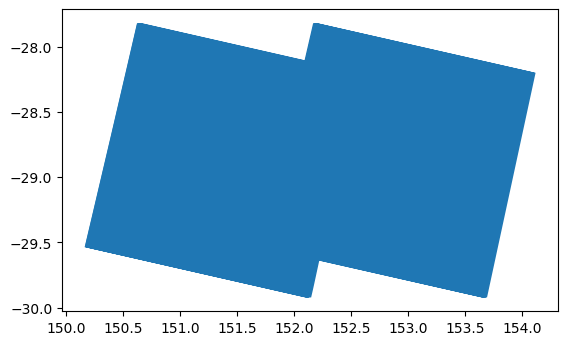

In [41]:
metadata_gdf = extract_stac_metadata(
    url=url,
    collections=[sensor_name],
    bbox=gdf.iloc[:5].dissolve().total_bounds.tolist(),
    time_range="2025-01-01/2025-12-31"
)
display(metadata_gdf)

# Now you can do spatial operations
metadata_gdf.plot()  # Visualize footprints
# metadata_gdf.bounds  # Get bounding boxes

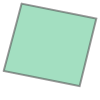

In [40]:
metadata_gdf.iloc[0].geometry

In [17]:
utilities.get_catalog_item(url)

<Client id=AWS_Explorer>

In [27]:
results = utilities.get_catalog_item(url).search(collections=sensor_name, max_items=1)
items = results.item_collection()

In [26]:
items

In [30]:
items[0].properties

{'title': 'ga_ls8c_ard_3-0-0_097070_2013-03-19_final',
 'gsd': 15.0,
 'gqa:abs_x': 0.38,
 'gqa:abs_y': 0.43,
 'gqa:cep90': 0.61,
 'fmask:snow': 0.0,
 'gqa:abs_xy': 0.58,
 'gqa:mean_x': 0.1,
 'gqa:mean_y': 0.05,
 'proj:shape': [7381, 7431],
 'platform': 'landsat-8',
 'fmask:clear': 62.80480553488141,
 'fmask:cloud': 12.885049517241479,
 'fmask:water': 20.94866296820271,
 'gqa:mean_xy': 0.11,
 'odc:product': 'ga_ls8c_ard_3',
 'gqa:stddev_x': 1.17,
 'gqa:stddev_y': 1.47,
 'odc:producer': 'ga.gov.au',
 'instruments': ['oli', 'tirs'],
 'gqa:stddev_xy': 1.88,
 'eo:cloud_cover': 12.885049517241479,
 'view:sun_azimuth': 68.19103861,
 'proj:transform': [30.0,
  0.0,
  672285.0,
  0.0,
  -30.0,
  -1489485.0,
  0.0,
  0.0,
  1.0],
 'landsat:wrs_row': 70,
 'odc:file_format': 'GeoTIFF',
 'odc:region_code': '097070',
 'end_datetime': '2013-03-19T00:30:23.202120Z',
 'view:sun_elevation': 56.53863005,
 'landsat:wrs_path': 97,
 'start_datetime': '2013-03-19T00:29:54.547586Z',
 'fmask:cloud_shadow': 3.3